In [ ]:
from datascience import *

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('fivethirtyeight')

import os
import zipfile
import requests
import io
import pandas as pd
import networkx as nx
import itertools

## Balance theory and signed networks

This notebook explores an example of a signed network.

The analysis is inspired by [Leskovec et al, 2010](https://dl.acm.org/citation.cfm?id=1753532), and the dataset we use here is a simplified version of one of the datasets those researchers studied. The simplified dataset comes from the [aminer data repository](https://aminer.org/data-sna). (You should consider this notebook an illustration of some of the concepts we've discussed in class, but this dataset is not research-quality.)

### Load the data

**Small slashdot data**

In [ ]:
# small version of slashdot dataset from from: 
# https://aminer.org/data-sna

#data_url = os.path.expanduser(os.path.join("~", "Dropbox", "data-explore", "slashdot-small", "slashdot.txt"))
#raw_data = pd.read_csv(data_url, sep="\t", skiprows=1, header=None) # skip the first row

## read the data in from the online repository
data_url = "http://arnetminer.org/lab-datasets/infer_social_tie_across_heter/Data/slashdot.zip"

import requests, zipfile, io
r = requests.get(data_url)

with zipfile.ZipFile(io.BytesIO(r.content)) as z:
    with z.open("slashdot.txt") as f:
        raw_data = pd.read_csv(f, sep="\t", skiprows=1, header=None) # skip the first row

# rename the columns
raw_data = raw_data.rename(index=str, columns={0 : "from", 1 : "to", 2 : "sign"})
raw_data.head()

#### Create a `networkx` object from the edge list

In [31]:
%%time

# create a network from the message logs
raw_net = nx.from_pandas_edgelist(raw_data, 
                                   source='from', 
                                   target='to', 
                                   edge_attr=['sign'], 
                                   create_using=nx.DiGraph())

print("Number of nodes: ", raw_net.number_of_nodes())
print("Number of edges: ", raw_net.number_of_edges())

Number of nodes:  13182
Number of edges:  36339
CPU times: user 108 ms, sys: 10.6 ms, total: 118 ms
Wall time: 117 ms


#### Convert directed network into an undirected network

Take the signed network and convert the signed, directed edges into signed, undirected edges.  
(The `to_undirected` function will produce an undirected edge between v1 and v2 if either there is a v1 -> v2 link, or a v2 -> v1 link. If both links exist, the data from one of the two is chosen arbitrarily to be the data for the undirected link.)

In [32]:
undir_net = raw_net.to_undirected()

Calculate the embeddedness of each edge and add it as an attribute (this will save time later)

In [33]:
%%time
for e in undir_net.edges:
    undir_net[e[0]][e[1]]['embeddedness'] = len(list(nx.common_neighbors(undir_net, e[0], e[1])))

CPU times: user 4.75 s, sys: 4.87 ms, total: 4.76 s
Wall time: 4.76 s


Define some functions for enumerating triangles and counting positive edges that will help us below.

In [34]:
def get_triangles(G):
    """
    see https://groups.google.com/forum/#!topic/networkx-discuss/baNlK-DU_B0
    """
    triangles =  [list(triple) for triple in set(frozenset((n,nbr,nbr2)) for n in G for nbr, nbr2 in itertools.combinations(G[n],2) if nbr in G[nbr2])]
    return(triangles)

def tri_count_positive_edges(net, triangles):
    """
    Given a network, calculate a histogram of the number of positive
    edges for all of the triangles (closed triads) in the network.
    
    Arguments:
      * net: a networkx Graph, assumed to have edge attributes called 'sign'
      * triangles: a list of list; each inner list has three node ids that describe a triangle
    
    Returns: 
      * a dictionary whose keys are 0, 1, 2, and 3, and whose values are the number
        of triangles with the corresponding number of positive edges.
    
    Example:
      > result = tri_count_positive_edges(my_network)
      # now result[2] will have the number of triangles with 
      # two positive edges and one negative edge in my_network
    """
    ## get triangles (which are cycles of length 3)
    #triangles = [x for x in nx.cycle_basis(net) if len(x) == 3]
    
    num_positive_edges = { 0: 0, 1: 0, 2: 0, 3:0}

    for tri in triangles:
        e0 = int(net[tri[0]][tri[1]]['sign'] > 0)
        e1 = int(net[tri[1]][tri[2]]['sign'] > 0)
        e2 = int(net[tri[2]][tri[0]]['sign'] > 0)
        cur_count = e0 + e1 + e2
        num_positive_edges[cur_count] = num_positive_edges[cur_count] + 1
        
    return(num_positive_edges)

We'll figure out where all of the triangles are in the network first;
this will save us some time later.

In [35]:
%%time
triangles = get_triangles(undir_net)

CPU times: user 3.16 s, sys: 17.9 ms, total: 3.18 s
Wall time: 3.19 s


As an example, let's calculate the distribution of the number of positive edges across triangles in the small Slashdot network we're analyzing here:

In [36]:
%%time
npe = tri_count_positive_edges(undir_net, triangles)
npe

CPU times: user 233 ms, sys: 1.85 ms, total: 235 ms
Wall time: 234 ms


{0: 157, 1: 1420, 2: 3449, 3: 74296}

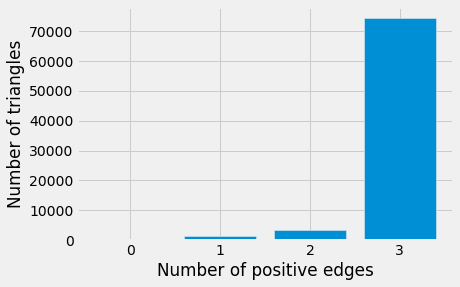

In [37]:
plt.bar(list(npe.keys()), npe.values());
plt.xlabel('Number of positive edges');
plt.ylabel('Number of triangles');
plt.show()

This function will help us start with the distribution of the number of positive edges across triangles (which we just plotted) and calculate the fraction of triads that is balanced:

In [38]:
def frac_tri_balanced(tri_pos_edge_counts):
    """
    Given a dictionary with the distribution of positive edges across triangles
    (produced by the function tri_count_positive_edges), calculate the fraction
    of triangles that is balanced. A triangle is balanced if it has one or three
    positive edges.
    
    Arguments:
      * tri_pos_edge_counts
    
    Returns: 
      * a networkx Graph with the same nodes and edges as net, with
        the signs on the edges randomly permuted
    
    Example:
      > shuffled_sign_net = permute_signs(my_network)
      # now shuffled_sign_net will have the same structure as my_network,
      # but the edges will have different signs
    """    
    num_triangles = sum(tri_pos_edge_counts.values())
    frac_balanced = (tri_pos_edge_counts[1] + tri_pos_edge_counts[3]) / num_triangles
    return(frac_balanced)

Calculate the fraction of triangles that is balanced in the observed network:

In [39]:
obsvd_counts = tri_count_positive_edges(undir_net, triangles)

obsvd_frac_balanced = frac_tri_balanced(obsvd_counts)
obsvd_frac_balanced

0.9545397241622753

### Is this evidence of balance?

So, does this evidence suggest that there is some process that encourages the Slashdot network to have structural balance?

It is hard to know without understanding what amount of structural balance we would expect to observe just by chance, in a world where no process was pushing triangles towards balance.

In other words, we need to posit a *null model* which we can compare our observed network to.

In this case, one reasonable null model might be to assume that the signs on the edges are assigned completely at random, with no attention paid to whether the triangles that result are balanced or not.  We can try to create alternate Slashdot networks that would be likely if the world worked this way by randomly reshuffling the signs on the network edges.

This function will take a given network and keep all of its structure, *except* that it will randomly reshuffle the signs on all of the edges. The total number of negative and positive edges will not change -- but whether one specific edge is negative or positive may change.

In [40]:
def permute_signs(unet, keep='embeddedness'):
    """
    Given a network with signed edges, return a copy of the network
    with the same nodes and edges, but with the signs on the edges
    randomly shuffled.
    
    Arguments:
      * unet: a networkx Graph, assumed to have edge attributes called 'sign'
    
    Returns: 
      * a networkx Graph with the same nodes and edges as net, with
        the signs on the edges randomly permuted
    
    Example:
      > shuffled_sign_net = permute_signs(my_network)
      # now shuffled_sign_net will have the same structure as my_network,
      # but the edges will have different signs
    """
    signs = nx.get_edge_attributes(unet, name='sign').values()
    new_signs = dict(zip(unet.edges, list(np.random.permutation(list(signs)))))
    
    new_net = nx.Graph()
    new_net.add_edges_from(unet.edges)

    #print('old number of edges: ', net.number_of_edges())    
    #print('new number of edges: ', new_net.number_of_edges())
    
    nx.set_edge_attributes(new_net, new_signs, name='sign')
    
    if keep is not None:
        to_keep = nx.get_edge_attributes(unet, name=keep)
        nx.set_edge_attributes(new_net, to_keep, name=keep)
    
    return(new_net)

In [41]:
def get_embed_pos(net, num_cat=10):
    """
    Given a network whose edges have attributes 'sign' and 'embeddedness',
    calculate the fraction of nodes that is positive for num_cat categories of
    embeddedness
    
    Arguments:
    
        * net - the network
        * num_cat - the number of embeddedness categories (or None to use actual embeddedness values)
        
    Returns:
    
        A pandas dataframe with the mean and standard deviation of the fraction of edges
        that is positive at each level of embeddedness
    """
    eldf = nx.to_pandas_edgelist(net)
    eldf['positive'] = (eldf['sign'] == 1)
    if num_cat is None:
        eldf['embed_cat'] = eldf['embeddedness']
    else:
        eldf['embed_cat'] = pd.cut(eldf['embeddedness'], num_cat)
        
    res = eldf.groupby('embed_cat').agg({'positive' : [np.mean, np.std]})
    res = res.xs('positive', axis=1, drop_level=True)
    res = res.reset_index()

    return(res)

We'll use the function to create many (say 500) alternate Slashdot networks under this null model.

In [ ]:
%%time
# NB: this takes about 7-12 minutes to run

permuted_frac_balanced = make_array()
permuted_count_list = []
embed_pos_list = []

triangles = get_triangles(undir_net)

for _ in np.arange(500):
    permuted_net = permute_signs(undir_net)
    cur_permuted_counts = tri_count_positive_edges(permuted_net, triangles)
    permuted_count_list.append(cur_permuted_counts)
    embed_pos_list.append(get_embed_pos(permuted_net))
    permuted_frac_balanced = np.append(frac_tri_balanced(cur_permuted_counts), 
                                       permuted_frac_balanced)
    
permuted_counts_df = pd.DataFrame(permuted_count_list)
embed_pos_df = pd.concat(embed_pos_list)

# also get the fraction positive by embeddedness for the observed net
obsvd_embed_pos = get_embed_pos(undir_net)

# save the results in a Table
null_frac_balanced = Table().with_columns('frac_balanced', permuted_frac_balanced)

Now `permuted_counts_df` has the counts for each permuted network:

In [42]:
permuted_counts_df.head()

,0,1,2,3
0,313,4860,26451,47698
1,338,4883,26495,47606
2,330,5178,26646,47168
3,298,4975,26514,47535
4,288,4909,26512,47613


And `null_frac_balanced` has the fraction of triads that is balanced for each permuted network:

In [43]:
null_frac_balanced

frac_balanced
0.65867
0.664431
0.656073
0.653514
0.646567
0.654043
0.64987
0.659477
0.663536
0.657913


This is the (estimated) expected fraction of balanced triangles under our null model:

In [44]:
np.mean(permuted_frac_balanced)

0.6615445651899851

Let's examine the distribution of the fraction of triads that is balanced under the null model.

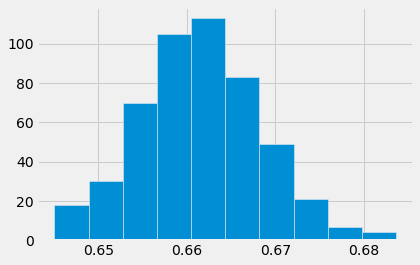

In [45]:
plt.hist(null_frac_balanced.column(0));
plt.show()

How consistent is this null distribution with the value we actually observed in the Slashdot network? 

Let's add the observed fraction balanced to our plot:

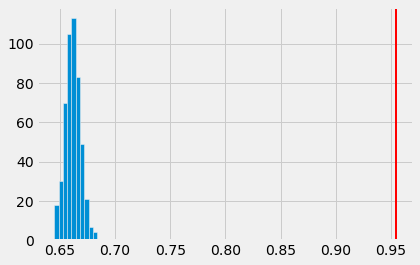

In [46]:
plt.hist(null_frac_balanced.column(0));
plt.axvline(x=obsvd_frac_balanced,c='red',linewidth=2);
plt.show()

The observed fraction of triads that is balanced is way higher than the values that come from the null model. Since the null model describes a world with no balance, we conclude that our observed network is much more balanced than we would expect if the null model were actually true.

### Deeper dive: strong and weak balance

We just analyzed the fraction of triads that is balanced in the observed network. Let's look a bit of a deeper dive and use the results from the null model to look at the expected and observed fraction of triads with 0, 1, 2, and 3 positive edges.

Recall that we permuted the signs a bunch of times and recorded the number of triads with 0, 1, 2, and 3 positive edges for each permutation. These counts are stored in `permuted_counts_df`:

In [47]:
permuted_counts_df.head()

,0,1,2,3
0,313,4860,26451,47698
1,338,4883,26495,47606
2,330,5178,26646,47168
3,298,4975,26514,47535
4,288,4909,26512,47613


We'll start by converting these counts into fractions:

In [48]:
# first, normalize each row to get the fraction of triads with the given number of positive edges
tot_edges = np.sum(permuted_counts_df.iloc[0])
permuted_counts_frac_df = permuted_counts_df.apply(lambda x: x / tot_edges, axis=1)
permuted_counts_frac_df.head()

,0,1,2,3
0,0.003946,0.061269,0.333464,0.601321
1,0.004261,0.061559,0.334018,0.600161
2,0.004160,0.065278,0.335922,0.594640
3,0.003757,0.062719,0.334258,0.599266
4,0.003631,0.061887,0.334233,0.600250


Now let's look at the expected fraction of triads with 0, 1, 2, and 3 positive edges under the null model:

In [ ]:
#permuted_counts_frac_df.apply([np.mean, np.std])

In [49]:
permuted_counts_frac_df.apply(np.mean)

0    0.003874
1    0.062263
2    0.334581
3    0.599282
dtype: float64

In [50]:
permuted_counts_frac_df.apply(np.std)

0    0.000395
1    0.003430
2    0.006462
3    0.010058
dtype: float64

What are the observed fractions? Let's see:

In [51]:
tot_edges = np.sum(list(obsvd_counts.values()))
obsvd_count_frac = pd.Series(obsvd_counts).apply(lambda x: x / tot_edges)
obsvd_count_frac

0    0.001979
1    0.017902
2    0.043481
3    0.936638
dtype: float64

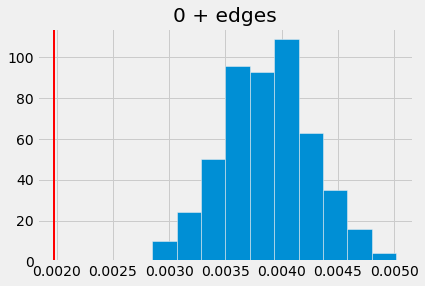

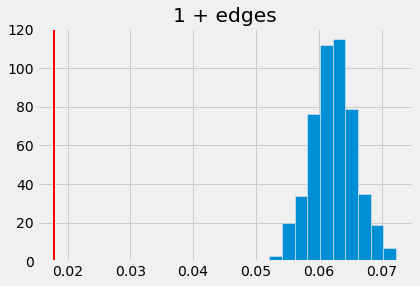

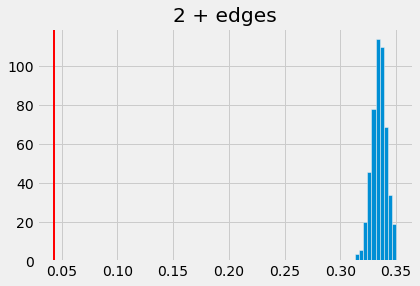

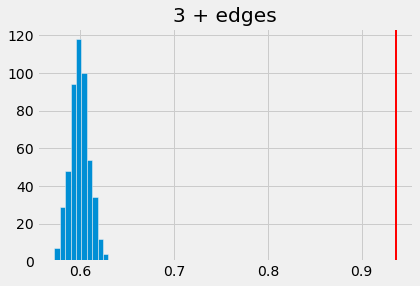

In [52]:
for num_pos in range(4):
    permuted_counts_frac_df.hist(num_pos);
    plt.axvline(x=obsvd_count_frac[num_pos],c='red',linewidth=2);
    plt.title(str(num_pos) + ' + edges');
    plt.show()

The findings here are similar to Leskovec et al (2010):

Consistent with balance theory, we find

* T3 is heavily overrepresented
* T2 is heavily underrepresented

We also see

* T0 is somewhat underrepresented
* T1 is somewhat underrepresented

These last two findings are a little harder to fit into strong balance theory; we would expect T1 to be overrepresented if the theory held perfectly.

### Are positive edges more embedded than negative edges?

`embed_pos_df` has the fraction positive by embeddedness for each permuted network:

In [53]:
embed_pos_df.head()

,embed_cat,mean,std
0,"(-0.214, 21.4]",0.843396,0.363433
1,"(21.4, 42.8]",0.837413,0.369069
2,"(42.8, 64.2]",0.825549,0.379757
3,"(64.2, 85.6]",0.839050,0.367970
4,"(85.6, 107.0]",0.892857,0.310219


For the relationship between embeddedness and frac of edges that is positive, aggregate up across the permuted networks to get the expected values across permuted networks.

In [54]:
embed_pos_agg_df = embed_pos_df.groupby('embed_cat').agg({'mean' : [np.mean, np.std]})
embed_pos_agg_df = embed_pos_agg_df.xs('mean', axis=1, drop_level=True).reset_index()
#embed_pos_agg_df.plot(x='embed_cat', y='mean')
embed_pos_agg_df

,embed_cat,mean,std
0,"(-0.214, 21.4]",0.842984,0.000682
1,"(21.4, 42.8]",0.843191,0.007397
2,"(42.8, 64.2]",0.843074,0.013692
3,"(64.2, 85.6]",0.842675,0.019365
4,"(85.6, 107.0]",0.843476,0.028351
5,"(107.0, 128.4]",0.846034,0.046861
6,"(128.4, 149.8]",0.840889,0.059572
7,"(149.8, 171.2]",0.840421,0.084212
8,"(171.2, 192.6]",0.841667,0.153949
9,"(192.6, 214.0]",0.834000,0.178908


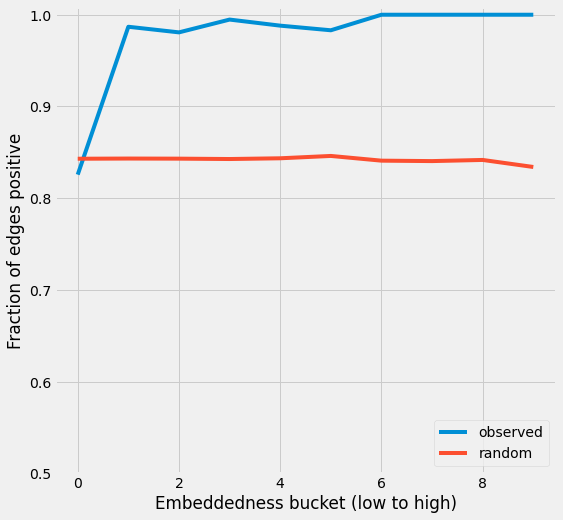

In [55]:
obsvd_embed_pos['source'] = 'observed'
embed_pos_agg_df['source'] = 'random'

embed_comp = pd.concat([obsvd_embed_pos, embed_pos_agg_df])
embed_comp['embed_order'] = embed_comp['embed_cat'].cat.codes

fig, ax = plt.subplots(figsize=(8,8))

for name, df in embed_comp.groupby('source'):
    df.plot(x='embed_order', y='mean', ax=ax, label=name);

plt.ylim(ymin=0.5);
plt.legend(loc='lower right');
plt.xlabel('Embeddedness bucket (low to high)');
plt.ylabel('Fraction of edges positive');
#fig.autofmt_xdate();